Please upload the file 'train and validation_WB.xlsx'.


Saving train and validation_WB.xlsx to train and validation_WB (7).xlsx
Please upload the file 'test_WB.xlsx'.


Saving test_WB.xlsx to test_WB (6).xlsx
Training data set metrics:
MSE: 668.980114141684, MAE: 16.662315085622215, RMSE: 25.86464989404813, R²: 0.9896530437734373
Validation data set metrics:
MSE: 1544.4818035857395, MAE: 25.31072317764792, RMSE: 39.299895719782, R²: 0.9751982208041821
WB_test data Set Metrics:
MSE: 4748.1071076487515, MAE: 36.42822700241414, RMSE: 68.90650990761868, R²: 0.9171934534507957


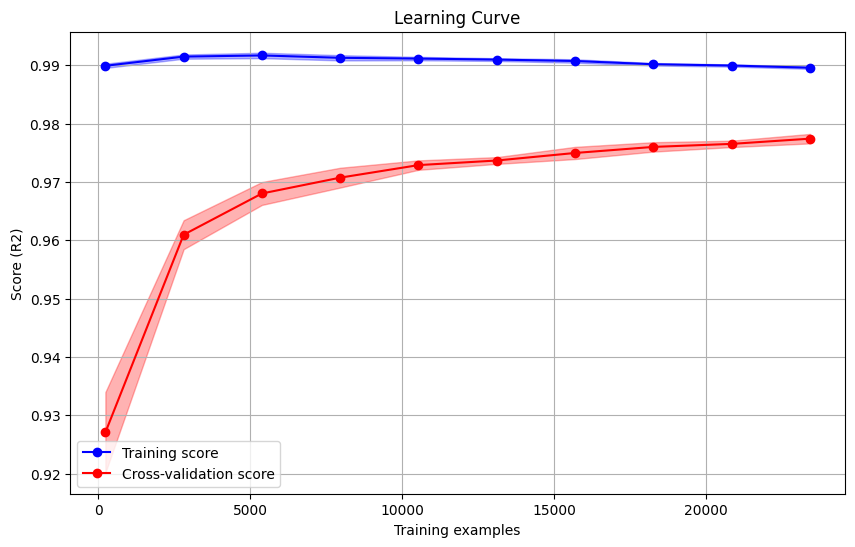

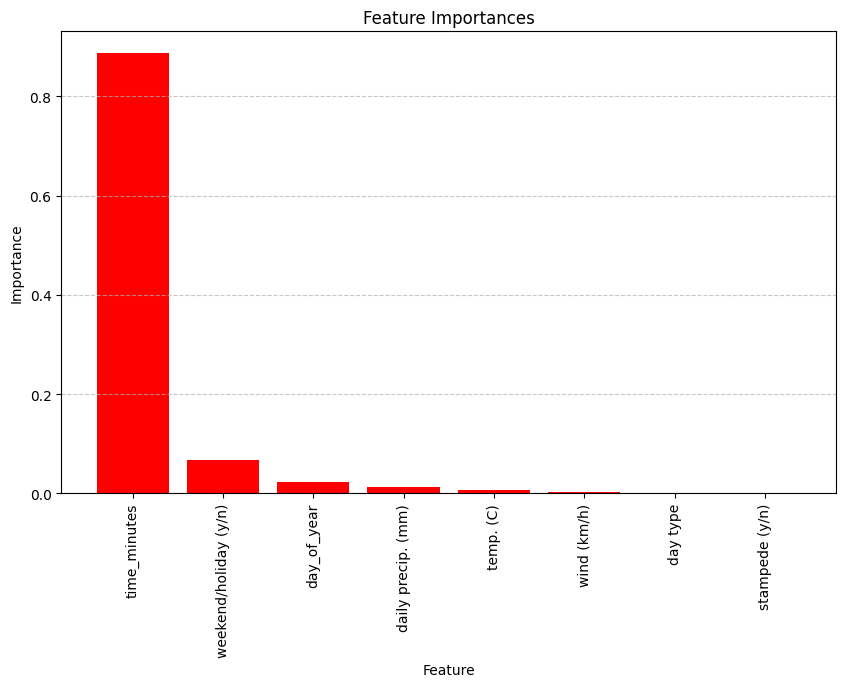

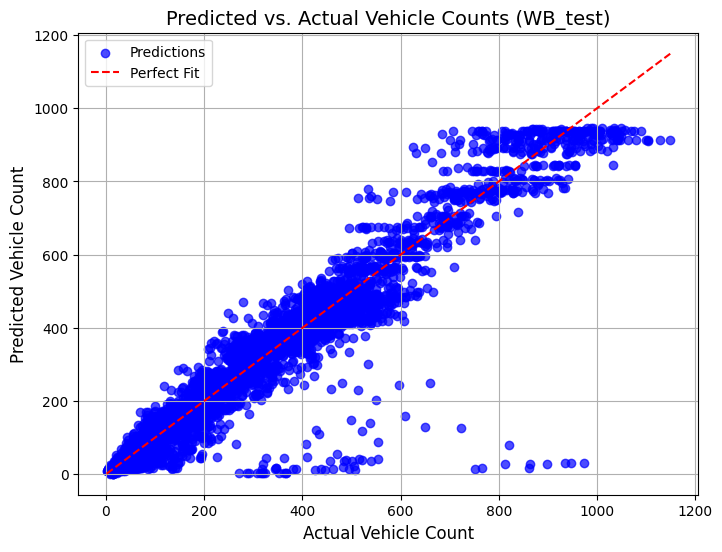

Enter Temperature (C): -15
Enter Daily Precipitation (mm): 0
Enter Wind Speed (km/h): 5
Is it a weekend or holiday? (y/n): y
Is it during Stampede? (y/n): n
Enter Day Type (Sunny/Rainy/Snowy): Sunny
Enter Date and Time (YYYY-MM-DD HH:MM:SS): 2024-11-30 17:00:00
Predicted Vehicle Count: 569.7178134287453


In [14]:
# Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from google.colab import files

# Step 1: Load Training and Validation Data
print("Please upload the file 'train and validation_WB.xlsx'.")
uploaded_train_val = files.upload()
data = pd.read_excel('train and validation_WB.xlsx')

# Step 2: Load Test Data
print("Please upload the file 'test_WB.xlsx'.")
uploaded_test = files.upload()
test_data = pd.read_excel('test_WB.xlsx')

# Step 3: Data Preparation
# Convert 'date' and 'time' columns to datetime objects
data['date'] = pd.to_datetime(data['date'])
data['time'] = pd.to_datetime(data['time'], format='%H:%M:%S')

# Extract additional features
data['hour'] = data['time'].dt.hour
data['minute'] = data['time'].dt.minute
data['day_of_year'] = data['date'].dt.dayofyear
data['time_minutes'] = data['hour'] * 60 + data['minute']

# Map categorical columns
data['day type'] = data['day type'].map({'Sunny': 0, 'Rainy': 1, 'Snowy': 2})
data['weekend/holiday (y/n)'] = data['weekend/holiday (y/n)'].map({'y': 1, 'n': 0})
data['stampede (y/n)'] = data['stampede (y/n)'].map({'y': 1, 'n': 0})

# Define the feature list
features = ['day_of_year', 'time_minutes', 'weekend/holiday (y/n)',
            'stampede (y/n)', 'temp. (C)', 'daily precip. (mm)',
            'wind (km/h)', 'day type']

# Shuffle and Split Training/Validation Data Only
data = data.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle data
X = data[features]
y = data['vehicle count']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing for Test Data (test_WB)
test_data['date'] = pd.to_datetime(test_data['date'])
test_data['time'] = pd.to_datetime(test_data['time'], format='%H:%M:%S')
test_data['hour'] = test_data['time'].dt.hour
test_data['minute'] = test_data['time'].dt.minute
test_data['day_of_year'] = test_data['date'].dt.dayofyear
test_data['time_minutes'] = test_data['hour'] * 60 + test_data['minute']
test_data['day type'] = test_data['day type'].map({'Sunny': 0, 'Rainy': 1, 'Snowy': 2})
test_data['weekend/holiday (y/n)'] = test_data['weekend/holiday (y/n)'].map({'y': 1, 'n': 0})
test_data['stampede (y/n)'] = test_data['stampede (y/n)'].map({'y': 1, 'n': 0})

X_WB_test = test_data[features]
y_WB_test = test_data['vehicle count']

# Step 4: Train Model
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, 15]
}
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate on Training and Validation Set
y_val_pred = best_model.predict(X_val)
y_train_pred = best_model.predict(X_train)

# Step 5: Evaluate on the data sets of training and validation (data) and test data set (test_data)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)
print(f"Training data set metrics:")
print(f"MSE: {train_mse}, MAE: {train_mae}, RMSE: {train_rmse}, R²: {train_r2}")

val_mse = mean_squared_error(y_val, y_val_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)
val_r2 = r2_score(y_val, y_val_pred)
print(f"Validation data set metrics:")
print(f"MSE: {val_mse}, MAE: {val_mae}, RMSE: {val_rmse}, R²: {val_r2}")

y_WB_test_pred = best_model.predict(X_WB_test)
WB_test_mse = mean_squared_error(y_WB_test, y_WB_test_pred)
WB_test_mae = mean_absolute_error(y_WB_test, y_WB_test_pred)
WB_test_rmse = np.sqrt(WB_test_mse)
WB_test_r2 = r2_score(y_WB_test, y_WB_test_pred)
print(f"WB_test data Set Metrics:")
print(f"MSE: {WB_test_mse}, MAE: {WB_test_mae}, RMSE: {WB_test_rmse}, R²: {WB_test_r2}")

# Step 6: Visualizations

# Learning Curve
def plot_learning_curve(estimator, title, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 10)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score (R2)")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.3, color="blue")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.3, color="red")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="blue", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="red", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

plot_learning_curve(best_model, "Learning Curve", X, y, cv=5, n_jobs=-1)

# Feature Importances
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

# Prediction vs. Actual Scatter Plot for WB_test
plt.figure(figsize=(8, 6))
plt.scatter(y_WB_test, y_WB_test_pred, alpha=0.7, color='blue', label='Predictions')
perfect_fit_min = min(min(y_WB_test), min(y_WB_test_pred))
perfect_fit_max = max(max(y_WB_test), max(y_WB_test_pred))
plt.plot([perfect_fit_min, perfect_fit_max], [perfect_fit_min, perfect_fit_max], '--', color='red', label='Perfect Fit')
plt.title("Predicted vs. Actual Vehicle Counts (WB_test)", fontsize=14)
plt.xlabel("Actual Vehicle Count", fontsize=12)
plt.ylabel("Predicted Vehicle Count", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()

# Step 7
def predict_vehicle_count():
  """
  Takes user input for features and returns predicted vehicle count.
  """
  # Request user input for each feature
  temp = float(input("Enter Temperature (C): "))
  precip = float(input("Enter Daily Precipitation (mm): "))
  wind = float(input("Enter Wind Speed (km/h): "))
  weekend = input("Is it a weekend or holiday? (y/n): ").strip().lower()
  weekend = 1 if weekend == 'y' else 0
  stampede = input("Is it during Stampede? (y/n): ").strip().lower()
  stampede = 1 if stampede == 'y' else 0
  day_type = input("Enter Day Type (Sunny/Rainy/Snowy): ").strip().capitalize()
  day_type = {'Sunny': 0, 'Rainy': 1, 'Snowy': 2}.get(day_type, 0)  # Default to Sunny if input is unrecognized

  # Extract day and time from user-provided date (assuming YYYY-MM-DD format)
  date_str, time_str = input("Enter Date and Time (YYYY-MM-DD HH:MM:SS): ").split()

  # Convert date and time to appropriate formats
  date = pd.to_datetime(date_str)
  time = pd.to_datetime(time_str, format='%H:%M:%S')

  # Calculate dayofyear and time_minutes from user-provided date and time
  dayofyear = date.dayofyear
  time_minutes = time.hour * 60 + time.minute

  # Prepare input data as a DataFrame
  input_data = pd.DataFrame([[dayofyear, time_minutes, weekend, stampede, temp, precip, wind, day_type]], columns=features)

  # Make prediction
  predicted_count = best_model.predict(input_data)
  print(f"Predicted Vehicle Count: {predicted_count[0]}")

# Run the function to get a prediction
predict_vehicle_count()

